### Predicting the number of rider who cross the fremont bridge by bicycle

In 2012 the city of Seattle installed induction loop counters on both sides of the Fremont bridge. The detect metal, like bicycles, passing over them every day. The fremont bridge is the main artery to get into downtown from anywhere North of Lake Union. The data is free and made available to the public VIA the Seattle City data portal

https://data.seattle.gov/Transportation/Fremont-Bridge-Hourly-Bicycle-Counts-by-Month-Octo/65db-xm6k

I wanted to add in environmetal factors and see if a liner regression model could predict how many riders would pass over the bridge on any given day and time. The next two cells are packages I would use as well as a few functions for later.

In [1]:
#Project Imports

import pandas as pd
from pandas import Series
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


from functools import reduce

import requests



from sklearn.linear_model import LinearRegression,Lasso,Ridge,RidgeCV,LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import neighbors


from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.features.importances import FeatureImportances

from sodapy import Socrata



from functools import reduce
from datetime import timezone, datetime,date
import pytz

pac = pytz.timezone('America/Los_Angeles')
utc = pytz.timezone('UTC')
%matplotlib inline

In [2]:
#Project Helper Functions

#Bulk hourly WX observations came in Kelvin
def Kel_To_Far(k):
    f = 1.8*(k - 273) + 32
    return f



##Function to determine season
#def get_season(now):
#    if isinstance(now, datetime):
#        now = now.date()
#    now = now.replace(year=Y)
#    return next(season for season, (start, end) in seasons
#                if start <= now <= end)
#
#Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
#seasons = [('Winter', (date(Y,  1,  1),  date(Y,  3, 20))),
#           ('Spring', (date(Y,  3, 21),  date(Y,  6, 20))),
#           ('Summer', (date(Y,  6, 21),  date(Y,  9, 22))),
#           ('Autumn', (date(Y,  9, 23),  date(Y, 12, 20))),
#           ('Winter', (date(Y, 12, 21),  date(Y, 12, 31)))]

## Seattle Data API
Everything from the Seattle Data Portal is made available through an API service named Socrata. This service has it's own python packages so I did not have to create URL's to pass. This also allowed me to get the most recent data for the Fremont bridge crossings

In [3]:
#load bike data from Seatlle data API
socrata_domain = 'data.seattle.gov'
socrata_dataset_identifier = '65db-xm6k'
socrata_token  = 'uTBE5rW06JBkufq8UsBellVPy'

client = Socrata(socrata_domain, socrata_token)

results = client.get(socrata_dataset_identifier 
                     ,where= "Date >= '2010-11-01T03:00:00.000' "
                     ,limit = 100000
                    )
fremont = pd.DataFrame.from_records(results)

## Bridge Data cleaning

The bridge data starts as 3 columns. A datetime field, and two integer columns corresponding to the East and West side of the bridge. Timezones ended up being pretty important. I would need the Weather observations and the bike crossings to be in Pacific time to ensure I could join on the date field correctly. They started as "Naive" time or without a timezone. Using a pandas function I was able to make the datetime field "Aware" of the Pacific timezone they actually were in.

In [4]:
#Convert date column and set as index

fremont['date'] = pd.to_datetime(fremont.date)
fremont.set_index('date',inplace = True)
fremont.index.names =['Date_Join']

#Convert to numeric columns
fremont['fremont_bridge_nb'] = pd.to_numeric(fremont['fremont_bridge_nb'])
fremont['fremont_bridge_sb'] = pd.to_numeric(fremont['fremont_bridge_sb'])


#Set timezone and sort index
fremont = fremont.tz_localize(pac,ambiguous = True, nonexistent = 'shift_forward')
fremont.sort_index(inplace = True)

#rename
fremont.rename(columns = {'fremont_bridge_nb' : 'EastSide',
                         'fremont_bridge_sb':'WestSide'
                         } , inplace= True)

#FillNA values with mean
fremont['WestSide'].fillna(value = fremont['WestSide'].mean(),inplace = True)
fremont['EastSide'].fillna(value = fremont['EastSide'].mean(),inplace = True)


#calculated Columns
fremont['Mean_Xing'] = fremont[['WestSide','EastSide']].mean(axis=1)
fremont['Total_Xing'] = fremont[['EastSide','WestSide']].sum(axis=1)
fremont['Time_of_Day'] = fremont.index.strftime('%H')
fremont['Month'] = fremont.index.strftime('%m')



print('You have Bridge data from {} to {}'.format(fremont.index.min().strftime('%m/%d/%Y-%I%p'),fremont.index.max().strftime('%m/%d/%Y-%I%p')))
print('There are {} observations and {} columns'.format(fremont.shape[0],fremont.shape[1]))
print(fremont.dtypes)

You have Bridge data from 10/03/2012-12AM to 05/31/2019-11PM
There are 58368 observations and 6 columns
EastSide       float64
WestSide       float64
Mean_Xing      float64
Total_Xing     float64
Time_of_Day     object
Month           object
dtype: object


## Hourly Weather Observations

For $10 I was able to buy a CSV file of hourly weather observations from https://openweathermap.org. This could have been accessed VIA API but required a subscription. This data came in some strange units. Degrees Kelvin for the temperature, a UTC timestamp. Luckily the UTC timestamp format was standared and I could match the format easily to convert it to an "Aware" datetime. From there I converted the UTC time to Pacific.


In [5]:
#load Weather Data
path = './Data/OpenWeatherMap/OpenWeatherMap_Seattle_Bulk.csv'
WX = pd.read_csv(path)

#format date column and set as index. Convert to Pacifict time. Original data in UTC
WX['dt_iso']=pd.to_datetime(WX['dt_iso'], format = '%Y-%m-%d %H:%M:%S +%f %Z' )
WX = WX.set_index('dt_iso')
WX = WX.tz_convert(pac)
WX.index.names =['Date_Join']


#convert temps from Kelving to Farenheit
WX['temp_f'] = WX.temp.apply(Kel_To_Far)
WX['temp_min_f'] = WX.temp_min.apply(Kel_To_Far)
WX['temp_max_f'] = WX.temp_max.apply(Kel_To_Far)



#drop unused column and re-order logically
WX.drop(['lat','lon','city_id','city_name','temp','temp_min','temp_max','sea_level','grnd_level','dt','weather_icon'],axis = 1,inplace=True)
WX.drop(['rain_3h','snow_3h','rain_24h','snow_24h','rain_today','snow_today'],axis = 1,inplace=True)
WX.drop(['weather_main','weather_id'],axis = 1,inplace=True)
 
neworder =['temp_f','temp_min_f','temp_max_f','pressure', 'humidity', 'wind_speed', 'wind_deg',
            'rain_1h','snow_1h', #'rain_3h','snow_3h','rain_24h','snow_24h', 'rain_today','snow_today',
            'clouds_all','weather_description'#, 'weather_main','weather_id'
          ]
WX=WX.reindex(columns=neworder)


#fill NA data with 0
WX['rain_1h'].fillna(value = 0,inplace = True)
WX['snow_1h'].fillna(value = 0,inplace =True)

#Calculated Columns
WX['Time_of_Day'] = WX.index.strftime('%H')
WX['Month'] = WX.index.strftime('%m')
WX['WeekDay'] = WX.index.strftime('%A')


#Dummy Columns
WX = pd.get_dummies(data=WX,columns = ['weather_description','Time_of_Day','Month','WeekDay'])


#WX.head(5)
print('You have Weather data from {} to {}'.format(WX.index.min().strftime('%m/%d/%Y-%I%p'),WX.index.max().strftime('%m/%d/%Y-%I%p')))
print('There are {} observations and {} columns'.format(WX.shape[0],WX.shape[1]))
#print(WX.dtypes)

You have Weather data from 10/01/2012-06AM to 06/13/2019-05PM
There are 56675 observations and 87 columns


## Air Quality
Seattle gets quite a bit of smoke during the summers. I know it has deterred me from riding my bike a few times. I was able to find a publicly available air quality station in downtown seattle that had reporting capabilites from the Web.

https://fortress.wa.gov/ecy/enviwa/

https://fortress.wa.gov/ecy/enviwa/StationInfo.aspx?ST_ID=163

In [6]:
#Load Air Quality Data. Combine date and time column. Localize, already in PAC
path = './Data/Air_Quality/Seattle_Air_Quality.csv'
air = pd.read_csv(path,parse_dates=[['Date', 'Time']],index_col = 'Date_Time')
air = air.tz_localize(pac,ambiguous = True, nonexistent = 'shift_forward')
air.index.names =['Date_Join']

#Drop columns
air.drop(['Wind Spd S','Wind Dir S','Temp Amb 10m','UV_633','BC_633','Trace CO'],axis = 1,inplace=True)

#Fill na values with q quantile
q = .25
air.NO.fillna(value = air.NO.quantile(q),inplace = True)
air.NO2.fillna(value = air.NO2.quantile(q),inplace = True)
air.NOX.fillna(value = air.NOX.quantile(q),inplace = True)
air.BAM_PM25.fillna(value = air.BAM_PM25.quantile(q),inplace = True)


print('You have Air data from {} to {}'.format(air.index.min().strftime('%m/%d/%Y-%I%p'),air.index.max().strftime('%m/%d/%Y-%I%p')))
print('There are {} observations and {} columns'.format(air.shape[0],air.shape[1]))



You have Air data from 10/03/2012-12AM to 04/30/2019-12AM
There are 57601 observations and 4 columns


## Merge together.

Using the reduce function I could merge all 3 DataFrame's together on their named index column. Each index column is in Pacific time

In [7]:
#merge DF's together on Pacifict TZ date_Join column

dfs = (fremont,WX,air)
data = reduce(lambda left,right: pd.merge(left,right,on = 'Date_Join'),dfs)

print('You have combined data from {} to {}'.format(data.index.min().strftime('%m/%d/%Y'),data.index.max().strftime('%m/%d/%Y')))
print(len(data),'Observations')

You have combined data from 10/03/2012 to 04/30/2019
55523 Observations


### View Correlations

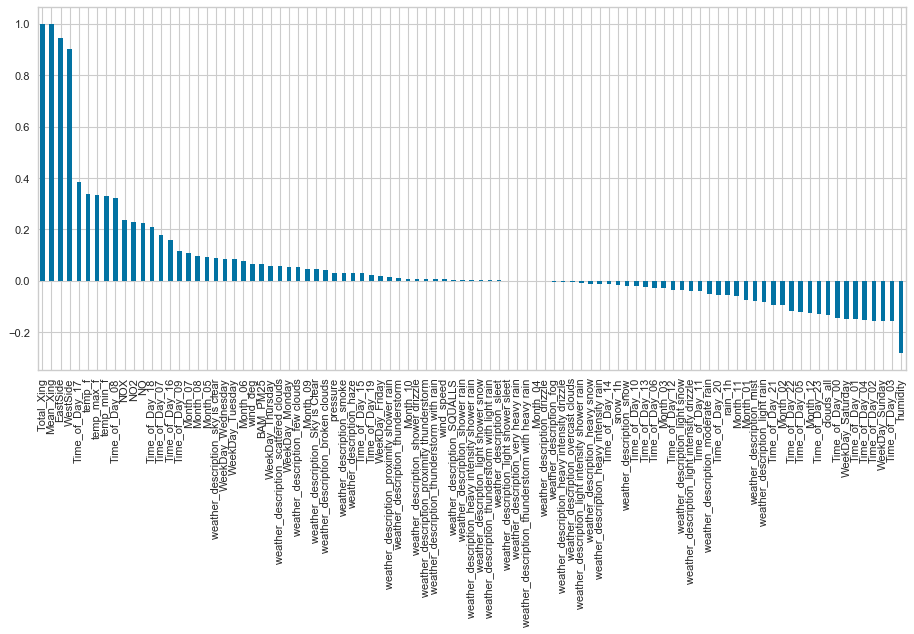

In [8]:
figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
corr = data.corr()
corr['Total_Xing'].sort_values(ascending=False).plot(kind='bar');

### Selecting Features
To avoid overfitting I used only 1 temperture field. For the same reason I eliminated the 'Season' column I had created earlier. The month works better than the season.

In [9]:
features = [
'temp_f',
#'temp_min_f',
#'temp_max_f',
#'pressure',
'humidity',
#'wind_speed',
#'wind_deg',
'rain_1h',
'snow_1h',
'clouds_all',
'weather_description_SQUALLS',
'weather_description_Sky is Clear',
'weather_description_broken clouds',
'weather_description_drizzle',
'weather_description_few clouds',
'weather_description_fog',
'weather_description_haze',
'weather_description_heavy intensity drizzle',
'weather_description_heavy intensity rain',
'weather_description_heavy intensity shower rain',
'weather_description_heavy snow',
'weather_description_light intensity drizzle',
'weather_description_light intensity shower rain',
'weather_description_light rain',
'weather_description_light shower sleet',
'weather_description_light shower snow',
'weather_description_light snow',
'weather_description_mist',
'weather_description_moderate rain',
'weather_description_overcast clouds',
'weather_description_proximity shower rain',
'weather_description_proximity thunderstorm',
'weather_description_scattered clouds',
'weather_description_shower drizzle',
'weather_description_shower rain',
'weather_description_sky is clear',
'weather_description_sleet',
'weather_description_smoke',
'weather_description_snow',
'weather_description_thunderstorm',
'weather_description_thunderstorm with heavy rain',
'weather_description_thunderstorm with light rain',
'weather_description_thunderstorm with rain',
'weather_description_very heavy rain',
#'Season_Autumn',
#'Season_Spring',
#'Season_Summer',
#'Season_Winter',
'Time_of_Day_00',
'Time_of_Day_01',
'Time_of_Day_02',
'Time_of_Day_03',
'Time_of_Day_04',
'Time_of_Day_05',
'Time_of_Day_06',
'Time_of_Day_07',
'Time_of_Day_08',
'Time_of_Day_09',
'Time_of_Day_10',
'Time_of_Day_11',
'Time_of_Day_12',
'Time_of_Day_13',
'Time_of_Day_14',
'Time_of_Day_15',
'Time_of_Day_16',
'Time_of_Day_17',
'Time_of_Day_18',
'Time_of_Day_19',
'Time_of_Day_20',
'Time_of_Day_21',
'Time_of_Day_22',
'Time_of_Day_23',
'Month_01',
'Month_02',
'Month_03',
'Month_04',
'Month_05',
'Month_06',
'Month_07',
'Month_08',
'Month_09',
'Month_10',
'Month_11',
'Month_12',
'WeekDay_Monday',
'WeekDay_Tuesday',
'WeekDay_Wednesday',
'WeekDay_Thursday',
'WeekDay_Friday',
'WeekDay_Saturday',
'WeekDay_Sunday',
'NO',
'NO2',
'NOX',
'BAM_PM25'
]

## Assign and Split features

X always remained my environmental features. I did alternate between 1 of 4 possible y values. EastSide and WestSide were untouched and original. The mean and total columns are the respective functions for the East and West numbers. I also created a seperate scaled X to see how it would perform with the model.

An important feature here was setting a baseline prediction. Whatever y was used I created a seperate list of the mean of that y to evaluate later.

In [10]:
X = data[features]


#y = data['EastSide']
#y = data['WestSide']
#y = data['Mean_Xing']
y = data['Total_Xing']


scaler = StandardScaler()
X_std = scaler.fit_transform(X)


C:\Users\cody.ringrissler\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\cody.ringrissler\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state= 23)
#X_train, X_test, y_train, y_test = train_test_split(X_std, y,random_state= 23)


#y_baseline = [data.EastSide.mean()] * len(y_test)
#y_baseline = [data.WestSide.mean()] * len(y_test)
#y_baseline = [data.Mean_Xing.mean()] * len(y_test)
y_baseline = [data.Total_Xing.mean()] * len(y_test)


print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

print(len(y_baseline))

(41642, 86)
(41642,)
(13881, 86)
(13881,)
13881


In [12]:
#X_train.dtypes#sample(15) #DF Index
#X_test.sample(15) #DF Index
#y_test.sort_values()#tail(15) #series Index
#y_train.sample(15) #series Index

## Choosing and fitting the model

Through trial and error I found that a Ridge regression gave me the best results. Since I had previoulsy saved baseline y values it was very easy to run the model and see if my predictions where getting closer than the mean.

In [13]:
#model = LinearRegression()
#model = LogisticRegression()
#model = Lasso(alpha=10)
model = Ridge(alpha=10)
#model = RidgeCV()###Ridge with cross validation built in???
#model = neighbors.KNeighborsRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#save model coeficients
coef = Series(model.coef_,features).sort_values(ascending=False)

#set negative predictons to 0???
#y_pred[y_pred < 0] = 10

print("R-squared = ", model.score(X_test, y_test)) 
print("RMSE = ",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("Baseline RMSE = ",np.sqrt(metrics.mean_squared_error(y_test, y_baseline)))


R-squared =  0.6765051659680014
RMSE =  79.51104211515185
Baseline RMSE =  139.7957029669938


## Model Evaluation Graphs

After running the model above I used a feature importance graph to view the coefficients and help with feature engineering.

Next up is a prediction error graph showing true values and predictions. With this graph I started to realize I was getting negative prediction values. Theoretically that makes sense, it's a linear function. With a certain set of values there will be negative results (raining at 2 AM). Of course there can't be negative bridge crossings but it's how the line fits.

Last up is a residual plot. Another view of the prediction error plot

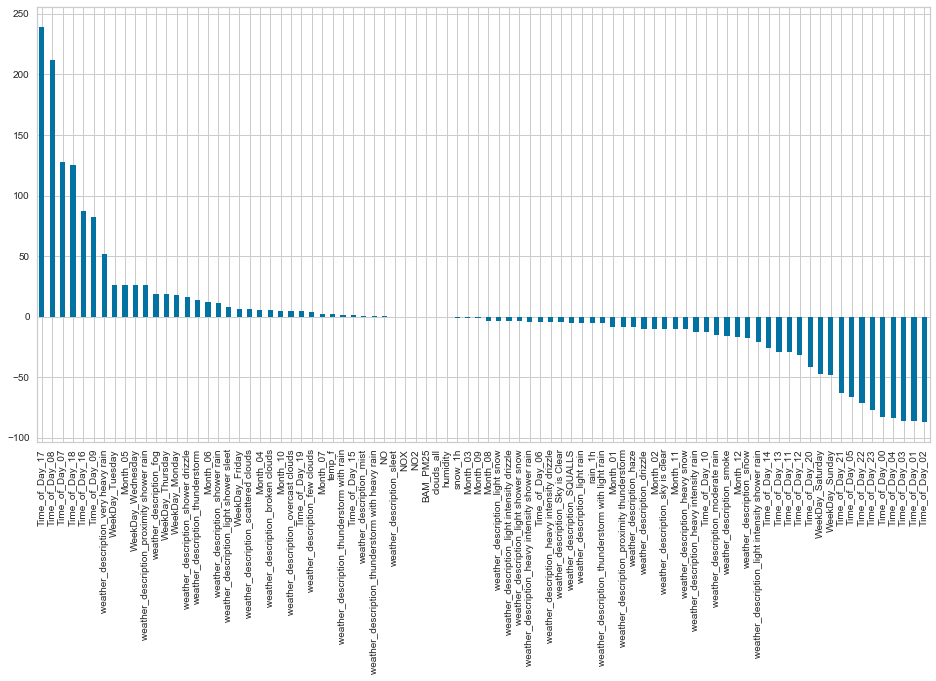

In [18]:
coef.plot(kind='bar')

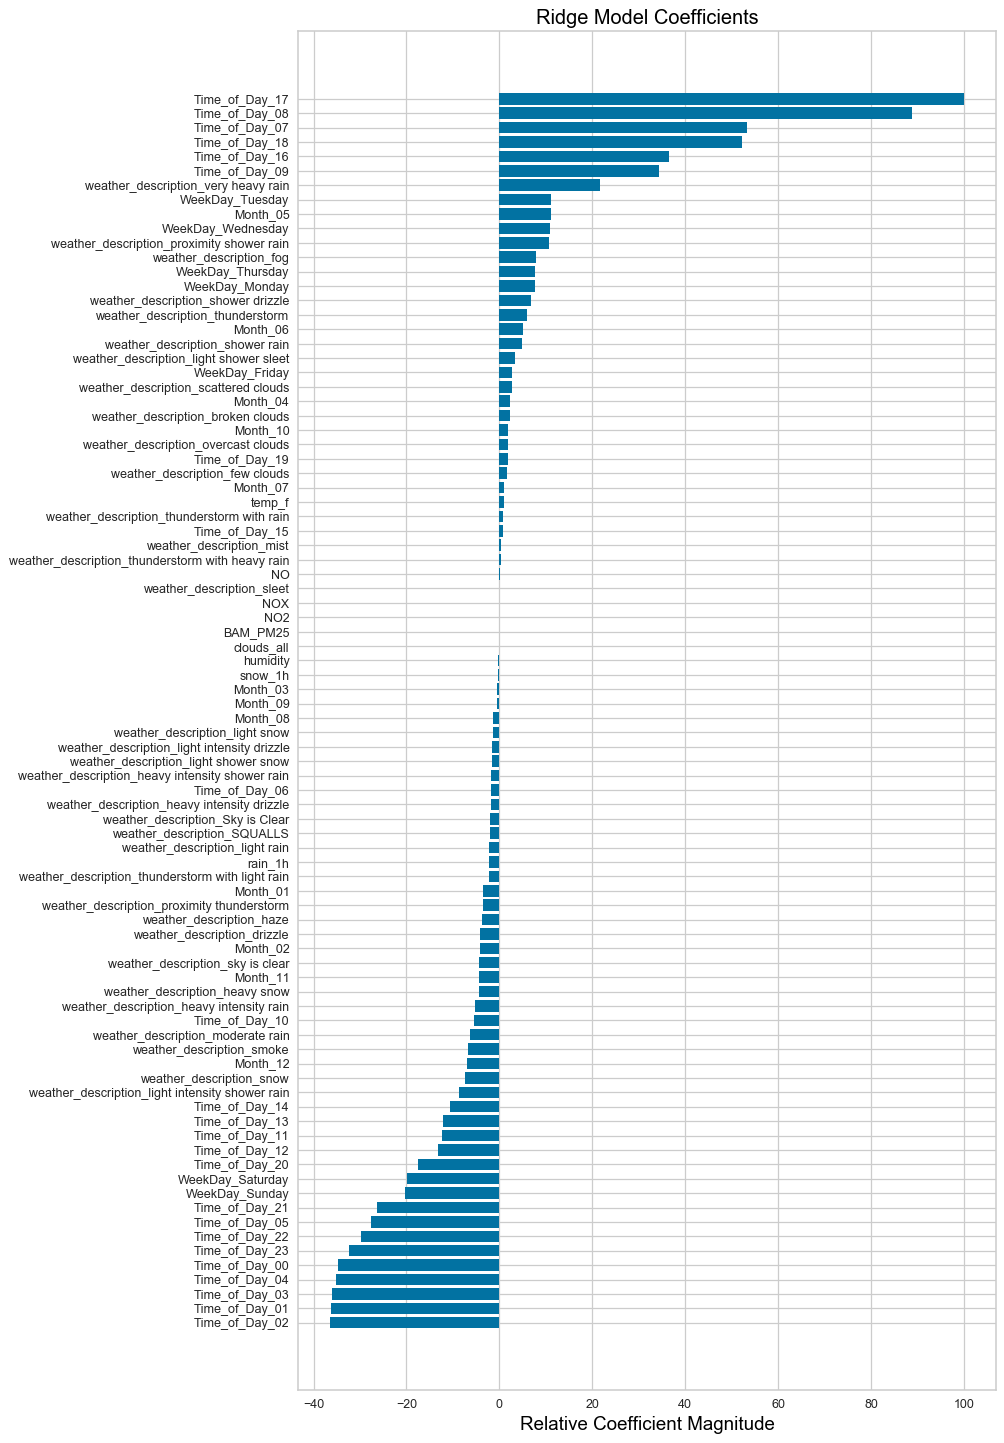

In [14]:
#with plt.rc_context({'xtick.color':'black', 'ytick.color':'black','font.size' : '15','lines.markersize': '15.0'}):
fig, ax = plt.subplots(figsize=(10,20),dpi=90)


visualizer = FeatureImportances(model,ax=ax)
visualizer.fit(X_train, y_train)
ax.set_xlabel("Relative Coefficient Magnitude", color="black",size=15)
ax.set_title('Ridge Model Coefficients', fontsize=16,color='black')

plt.savefig('./Figures/Hourly_Regression_Coefs.png')

    #ax.set_xlabel("Relative Coefficient Magnitude", color="black",size=15)
    #ax.set_ylabel('Temp', color="black",size=15)
    #ax.set_title('Feature Importances of 86 predictors using Ridge',color='black',size=25)

''

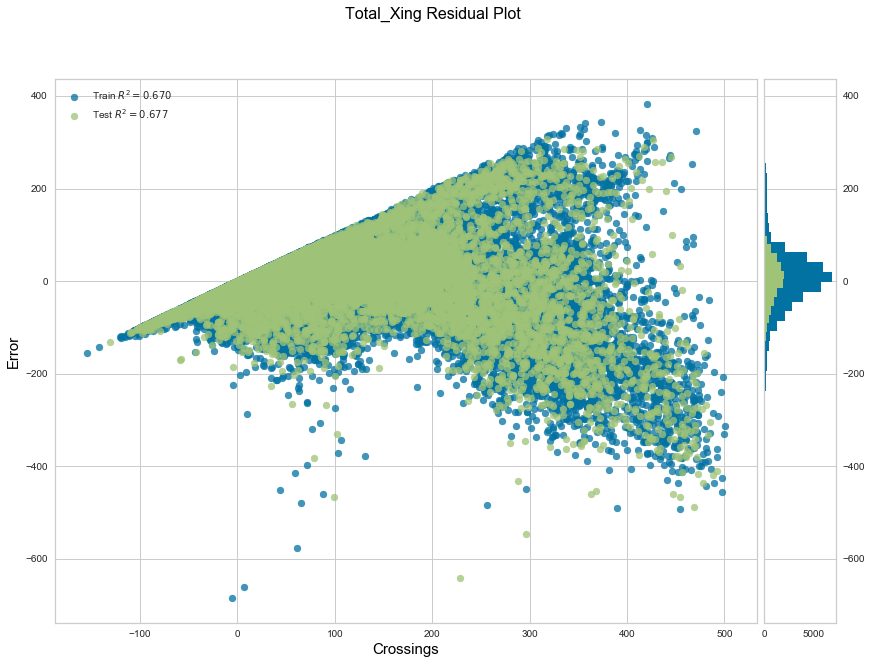

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize = [14,10])

visualizer = ResidualsPlot(model,ax=ax)
visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
#visualizer.poof()                 # Draw/show/poof the data



ax.set_xlabel("Crossings", color="black",size=15)
ax.set_ylabel("Error", color="black",size=15)
#ax.xtick.color('red')
fig.suptitle('Total_Xing Residual Plot', fontsize=16,color='black')

plt.legend()

#plt.show(visualizer)
#plt.show(visualizer.poof(ax=ax) )
plt.savefig('./Figures/Residuals_Hourly_Total_Xing.png')


#g = visualizer.poof(ax=ax)             # Draw/show/poof the data
;

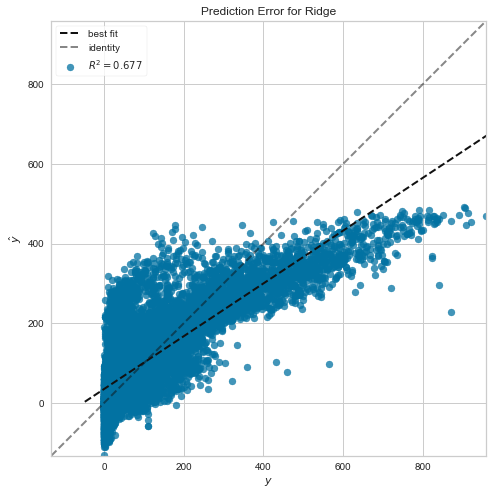

In [16]:
plt.rcParams['figure.figsize'] = (16, 8)

visualizer = PredictionError(model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

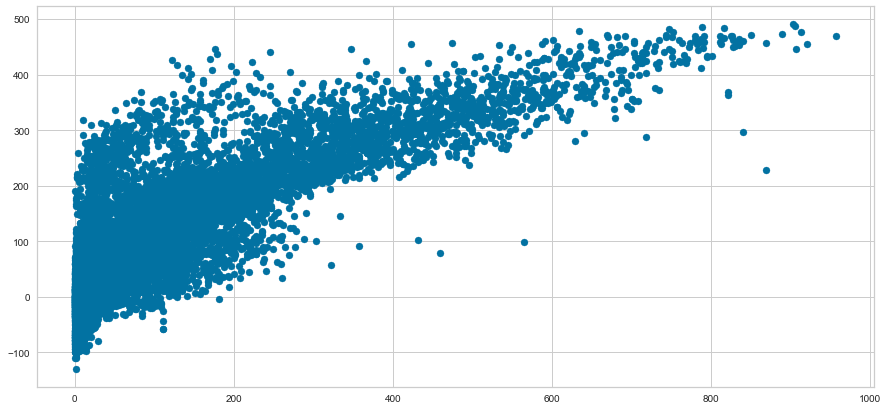

In [17]:
plt.figure(figsize = (15,7))
plt.scatter(x=y_test,y=y_pred, color = 'b')